# Lab 10: Convolutional Neural Networks

Today we'll experiment with CNNs. We'll start with a hand-coded CNN structure based on numpy, then we'll move to PyTorch.

## Hand-coded CNN

This example is based on [Ahmed Gad's tutorial](https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html).

We will implement a very simple CNN in numpy. The model will have
just three layers, a convolutional layer (conv for short), a ReLU activation layer, and max pooling. The major steps involved are as follows.
1. Reading the input image.
2. Preparing filters.
3. Conv layer: Convolving each filter with the input image.
4. ReLU layer: Applying ReLU activation function on the feature maps (output of conv layer).
5. Max Pooling layer: Applying the pooling operation on the output of ReLU layer.
6. Stacking the conv, ReLU, and max pooling layers.

### Reading an input image
 
The following code reads an existing image using the SciKit-Image Python library and converts it into grayscale. You may need to `pip install scikit-image`.

Image dimensions: (300, 451, 3)


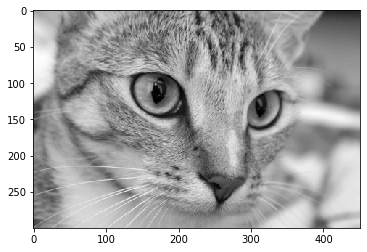

In [1]:
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Read image

img = skimage.data.chelsea()
print('Image dimensions:', img.shape)

# Convert to grayscale

img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap='gray')
plt.show()

### Create some filters for the conv layer

Recall that a conv layer uses some number of convolution (actually cross correlation) filters, usually matching the number
of channels in the input (1 in our case since the image is grayscale). Each kernel gives us one feature map (channel) in the
result.

Let's make two 3$\times$3 filters, using the horizontal and vertical Sobel edge filters:

In [2]:
l1_filters = np.zeros((2,3,3))
l1_filters[0, :, :] = np.array([[[-1, 0, 1], 
                                 [-2, 0, 2], 
                                 [-1, 0, 1]]])
l1_filters[1, :, :] = np.array([[[-1, -2, -1], 
                                 [ 0,  0,  0], 
                                 [ 1,  2,  1]]])

### Conv layer feedforward step
 
Let's convolve the input image with our filters.

In [3]:
# Perform stride 1 cross correlation of an image and a filter. We output the valid region only
# (no padding).

def convolve(img, conv_filter):
    stride = 1
    padding = 0
    filter_size = conv_filter.shape[1]
    results_dim = ((np.array(img.shape) - np.array(conv_filter.shape) + (2*padding))/stride) + 1
    result = np.zeros((int(results_dim[0]), int(results_dim[1])))
    
    for r in np.arange(0, img.shape[0] - filter_size + 1):
        for c in np.arange(0, img.shape[1]-filter_size + 1):          
            curr_region = img[r:r+filter_size,c:c+filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)
            result[r, c] = conv_sum
            
    return result       

# Perform convolution with a set of filters and return the result

def conv(img, conv_filters):
    # Check shape of inputs
    if len(img.shape) != len(conv_filters.shape) - 1: 
        raise Exception("Error: Number of dimensions in conv filter and image do not match.")  

    # Ensure filter depth is equal to number of channels in input
    if len(img.shape) > 2 or len(conv_filters.shape) > 3:
        if img.shape[-1] != conv_filters.shape[-1]:
            raise Exception("Error: Number of channels in both image and filter must match.")
            
    # Ensure filters are square
    if conv_filters.shape[1] != conv_filters.shape[2]: 
        raise Exception('Error: Filter must be square (number of rows and columns must match).')

    # Ensure filter dimensions are odd
    if conv_filters.shape[1]%2==0: 
        raise Exception('Error: Filter must have an odd size (number of rows and columns must be odd).')

    # Prepare output
    feature_maps = np.zeros((img.shape[0]-conv_filters.shape[1]+1, 
                             img.shape[1]-conv_filters.shape[1]+1, 
                             conv_filters.shape[0]))

    # Perform convolutions
    for filter_num in range(conv_filters.shape[0]):
        curr_filter = conv_filters[filter_num, :]
        # Our convolve function only handles 2D convolutions. If the input has multiple channels, we
        # perform the 2D convolutions for each input channel separately then add them. If the input
        # has just a single channel, we do the convolution directly.
        if len(curr_filter.shape) > 2:
            conv_map = convolve(img[:, :, 0], curr_filter[:, :, 0])
            for ch_num in range(1, curr_filter.shape[-1]):
                conv_map = conv_map + convolve(img[:, :, ch_num], 
                                      curr_filter[:, :, ch_num])
        else:
            conv_map = convolve(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map

    return feature_maps

Let's give it a try:

Convolutional feature maps shape: (298, 449, 2)


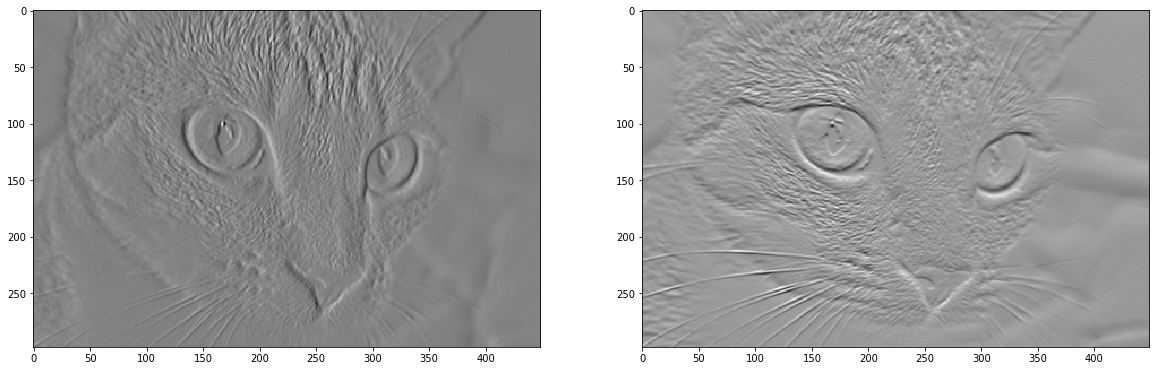

In [4]:
features = conv(img, l1_filters)

print('Convolutional feature maps shape:', features.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(features[:,:,0], cmap='gray')
ax2.imshow(features[:,:,1], cmap='gray')
plt.show()

Cool, right? A couple observations:
1. We've hard coded the values in the filters, so they are sensible to us. In a real CNN, we'd be tuning the filters to minimize loss on the training set, so we wouldn't expect such perfectly structured results.
2. Naive implementation of 2D convolutions requires 4 nested loops, which is super slow in Python. In the code above, we've replaced the two inner loops with an element-by-element matrix multiplication for the kernel and the portion of the image applicable for the current indices into the convoution result.

### In-class exercise

The semi-naive implementation of the convolution function above could be sped up with the use of a fast low-level 2D convolution routine that makes the best possible use of the CPU's optimized instructions, pipelining of operations, etc. Take a look at [Laurent Perrinet's blog on 2D convolution implementations](https://laurentperrinet.github.io/sciblog/posts/2017-09-20-the-fastest-2d-convolution-in-the-world.html) and see how the two fastest implementations,
scikit and numpy, outperform other methods and should vastly outperform the Python loop above. Reimplement the convolve() function above and compare
the times taken by the naive and optimized versions of your convolution operation for the cat image. In your report, briefly describe the experiment and the
results you obtained.



In [5]:
# Using module frm scipy
from scipy.signal import fftconvolve
def convolve1(A, B, prefetching=False):
    C = -fftconvolve(A, B, mode='valid')
    return C

In [6]:
#timing manual convolution vs scipy module convolution
%timeit convolve(img, l1_filters[1,:])

1.35 s ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit convolve1(img, l1_filters[1,:])

11 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
# also evaluating with numpy module
from numpy.fft  import fft2, ifft2
def convolve_opt2 (I,K):
    return np.real(ifft2(fft2(I) * fft2(K,s=I.shape)))[2:,2:]

In [9]:
%timeit convolve_opt2(img, l1_filters[1,:])

22.4 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We observe that convolution using these modules is faster than manual convolution

### Pooling and relu

Next, consider the feedforward pooling and ReLU operations.

In [10]:
# Pooling layer with particular size and stride

def pooling(feature_map, size=2, stride=2):
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                         np.uint16((feature_map.shape[1]-size+1)/stride+1),
                         feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size+1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

# ReLU activation function

def relu(feature_map):
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0,feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

Now let's try ReLU and pooling:

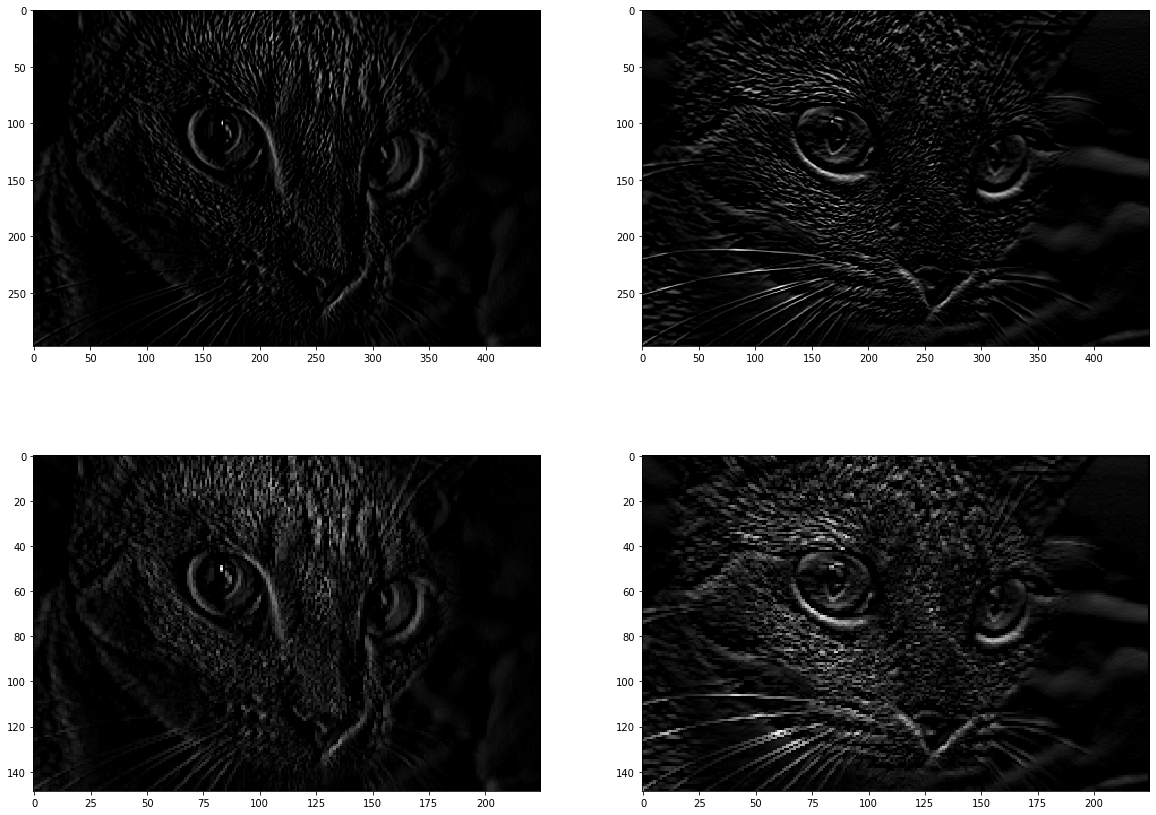

In [11]:
relued_features = relu(features)
pooled_features = pooling(relued_features)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
ax1.imshow(relued_features[:,:,0], cmap='gray')
ax2.imshow(relued_features[:,:,1], cmap='gray')
ax3.imshow(pooled_features[:,:,0], cmap='gray')
ax4.imshow(pooled_features[:,:,1], cmap='gray')
plt.show()


Let's visualize all of the feature maps in the model...

In [12]:
# First conv layer

print("conv layer 1...")
l1_feature_maps = conv(img, l1_filters)
l1_feature_maps_relu = relu(l1_feature_maps)
l1_feature_maps_relu_pool = pooling(l1_feature_maps_relu, 2, 2)

# Second conv layer

print("conv layer 2...")
l2_filters = np.random.rand(3, 5, 5, l1_feature_maps_relu_pool.shape[-1])
l2_feature_maps = conv(l1_feature_maps_relu_pool, l2_filters)
l2_feature_maps_relu = relu(l2_feature_maps)
l2_feature_maps_relu_pool = pooling(l2_feature_maps_relu, 2, 2)

# Third conv layer

print("conv layer 3...")
l3_filters = np.random.rand(1, 7, 7, l2_feature_maps_relu_pool.shape[-1])
l3_feature_maps = conv(l2_feature_maps_relu_pool, l3_filters)
l3_feature_maps_relu = relu(l3_feature_maps)
l3_feature_maps_relu_pool = pooling(l3_feature_maps_relu, 2, 2)


conv layer 1...
conv layer 2...
conv layer 3...


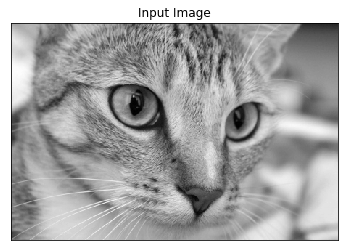

In [13]:
# Show results

fig0, ax0 = plt.subplots(nrows=1, ncols=1)
ax0.imshow(img).set_cmap("gray")
ax0.set_title("Input Image")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
plt.show()


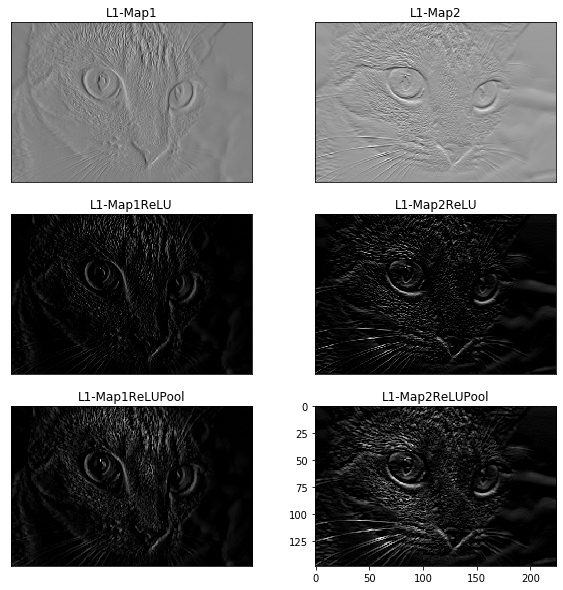

In [14]:
# Layer 1
fig1, ax1 = plt.subplots(nrows=3, ncols=2)
fig1.set_figheight(10)
fig1.set_figwidth(10)
ax1[0, 0].imshow(l1_feature_maps[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_maps[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

plt.show()


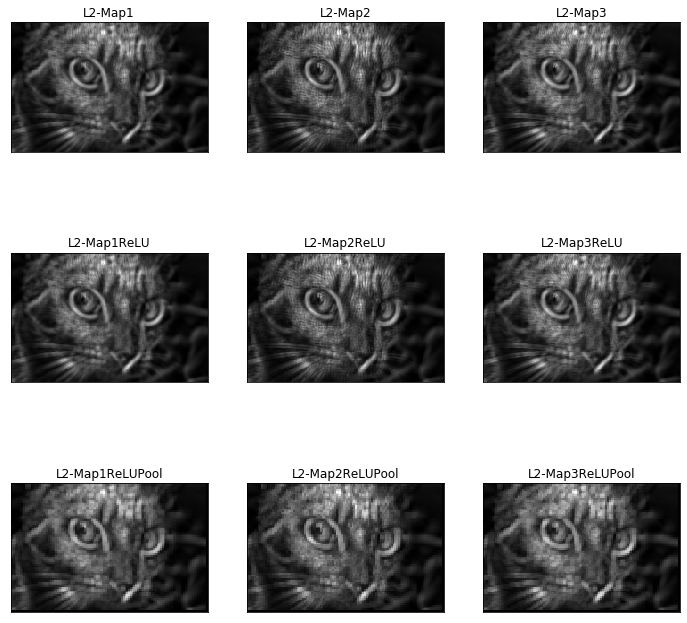

In [15]:
# Layer 2
fig2, ax2 = plt.subplots(nrows=3, ncols=3)
fig2.set_figheight(12)
fig2.set_figwidth(12)
ax2[0, 0].imshow(l2_feature_maps[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_maps[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_maps[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_maps_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_maps_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")
plt.show()

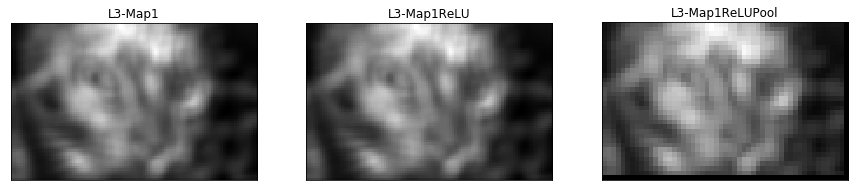

In [16]:
# Layer 3

fig3, ax3 = plt.subplots(nrows=1, ncols=3)
fig3.set_figheight(15)
fig3.set_figwidth(15)
ax3[0].imshow(l3_feature_maps[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")
plt.show()

We can see that at progressively higher layers of the network, we get coarser representations of the input. Since the filters at the later layers
are random, they are not very structured, so we get a kind of blurring effect. These visualizations would be more meaningful in model with learned
filters.

## CNNs in PyTorch

Now we'll do a more complete CNN example using PyTorch. We'll use the MNIST digits again. The example is based on
[Anand Saha's PyTorch tutorial](https://github.com/anandsaha/deep.learning.with.pytorch).

PyTorch has a few useful modules for us:
1. cuda: GPU-based tensor computations
2. nn: Neural network layer implementations and backpropagation via autograd
3. torchvision: datasets, models, and image transformations for computer vision problems.

torchvision itself includes several useful elements:
1. datasets: Datasets are subclasses of torch.utils.data.Dataset. Some of the common datasets available are "MNIST," "COCO," and "CIFAR." In this example we will see how to load MNIST dataset using a custom subclass of the datasets class.
2. transforms - Transforms are used for image transformations. The MNIST dataset from torchvision is in PIL image. 
To convert MNIST images to tensors, we will use `transforms.ToTensor()`.

### Take-home exercise

Apply the tech you've learned up till now to take Kaggle's 2013 [Dogs vs. Cats Challenge](https://www.kaggle.com/c/dogs-vs-cats). Download the training and test datasets and try to build the best PyTorch CNN you can for this dataset. Describe your efforts and the results in a brief lab report.